In [25]:
from torched_puff import puff_model
import torch
import os
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from unit_conversion import convert_wind


#### Test Case 1: downward wind, two sources and one active - sensors below. Data is noisy-ish, bc i'm eyeballing sensor vals

In [26]:
data_dir = f"{os.getcwd()}/data"
# load in data
df_wind_ch4 = pd.read_csv(data_dir + "/wind_ch4.csv")
df_true_emission = pd.read_csv(data_dir + "/selected_controll_release.csv")
source_points = torch.tensor(np.load(data_dir + "/source_points.npy")) # shape=(n_source, 3)
sensor_points = torch.tensor(np.load(data_dir + "/sensor_points.npy")) # shape=(n_sensor, 3)
#col_points = np.load(data_dir + "/col_points.npy")  # shape=(n_col, 3)
df_bounds = pd.read_csv(data_dir + "/bounds.csv", dtype='float32')
df_puff_simulation = pd.read_csv(data_dir + '/df_sim_puff_20220502008_0.csv')

tfinal = 5*60.
source_location = torch.tensor(source_points)

ws = df_wind_ch4['wind_speed.m/s'].to_numpy() # shape=(N_t,)
wd = df_puff_simulation['wind_direction'].to_numpy() # shape=(N_t,)
df_puff_simulation['x'], df_puff_simulation['y'] = convert_wind(ws,wd)

wind_function_x = lambda t : torch.tensor(interp1d(df_puff_simulation.index*60,df_puff_simulation.x)(t))
wind_function_y = lambda t : torch.tensor(interp1d(df_puff_simulation.index*60,df_puff_simulation.y)(t))

# sensor_names = ['N','W','SW','S','SE','E','NE','C1','NW']
sensor_names = ['N','E','SE','S','SW','W','NW','C1','NE']

num_sensors = len(sensor_names)
df_sensor = pd.DataFrame(sensor_points,columns = ['x','y','z'])
df_sensor['name'] = sensor_names
sensor_locations = df_sensor[['x','y']]
sensor_values_fn = dict()
for name in sensor_names:
    sensor_values_fn[name] = lambda t, f = interp1d(df_puff_simulation.index*60,df_puff_simulation[name]) : torch.tensor(f(t))
# ch4 = np.transpose(df_wind_ch4.iloc[:, 3:].to_numpy()) # shape=(N_obs, N_t)
sensor_names = df_wind_ch4.columns[3:]

C:\Users\andyh\AppData\Local\Temp\ipykernel_55272\3524995282.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source_location = torch.tensor(source_points)


#### Create observation data matrix of 100 obs across domain of 45 min


In [27]:
num_obs = 200
tbegin = 0*60
tend = 45*60
obs_t = torch.linspace(tbegin,tend,num_obs)
obs = torch.zeros(num_obs, num_sensors)
for i in range(num_obs):
    for j in range(num_sensors):
        obs[i,j] = torch.tensor(sensor_values_fn[sensor_names[j]](obs_t[i]))
print(obs.shape)

torch.Size([200, 9])


C:\Users\andyh\AppData\Local\Temp\ipykernel_55272\1195793286.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs[i,j] = torch.tensor(sensor_values_fn[sensor_names[j]](obs_t[i]))


In [28]:

pm = puff_model(source_location,sensor_points, [1,1,.25], wind_function_x, wind_function_y,[1,1],60)
Q_torch,p_torch, M_torch = pm.return_qp_matrices_new(obs,obs_t,spread=True)


In [29]:
sparse_coef = .4*torch.norm(p_torch,1)
# sparse_coef = 0
p_torch_n = p_torch+ sparse_coef*torch.ones(p_torch.shape)
Q = Q_torch.detach().numpy()
p = p_torch_n.reshape(-1).detach().numpy()
G = torch.cat([-1*torch.eye(p.size),torch.eye(p.size),
               torch.ones(1,5)]).detach().numpy()
h = torch.cat([torch.zeros(p.size),100*torch.ones(p.size),torch.tensor([30])]).detach().numpy()

#only constrain non-negativity
G = torch.cat([-1*torch.eye(p.size)]).detach().numpy()
h = torch.cat([torch.zeros(p.size)]).detach().numpy()

In [30]:
from cvxopt import matrix, solvers
Q = matrix(Q.astype(np.double))
p = matrix(p.astype(np.double))
G = matrix(G.astype(np.double))
h = matrix(h.astype(np.double))
# Q = 2*matrix([ [2, .5], [.5, 1] ])
# p = matrix([1.0, 1.0])
# G = matrix([[-1.0,0.0],[0.0,-1.0]])
# h = matrix([0.0,0.0])
# A = matrix([1.0, 1.0], (1,2))
# b = matrix(1.0)
# sol=solvers.qp(Q, p, G, h, A, b)
sol = solvers.qp(Q,p,G,h)
x = sol['x']


     pcost       dcost       gap    pres   dres
 0: -3.3931e-03  8.9207e-02  5e+00  2e+00  2e+00
 1:  7.9153e-02 -1.1797e-01  2e-01  6e-02  5e-02
 2:  1.9036e-02 -9.6939e-02  1e-01  3e-02  3e-02
 3:  4.8021e+03 -5.5346e+03  1e+04  2e-16  6e-17
 4:  7.5247e+02 -9.1576e+02  2e+03  4e-12  1e-14
 5:  6.4738e+01 -1.6742e+02  2e+02  4e-12  4e-17
 6: -1.8156e+01 -4.6319e+01  3e+01  9e-13  2e-17
 7: -2.4131e+01 -2.5828e+01  2e+00  5e-13  4e-18
 8: -2.4243e+01 -2.4262e+01  2e-02  9e-13  2e-18
 9: -2.4244e+01 -2.4244e+01  2e-04  5e-13  2e-17
10: -2.4244e+01 -2.4244e+01  2e-06  3e-20  1e-17
Optimal solution found.


In [31]:
print(sol['x'])
x = sol['x']
for i in range(len(x)):
    print(i+1,torch.norm(M_torch[:,i]- obs.T.reshape(-1,1),2))

[ 3.86e-06]
[ 8.25e-07]
[ 3.33e+03]
[ 6.12e-07]
[ 6.05e-07]

1 tensor(2909.5554)
2 tensor(2909.5532)
3 tensor(2909.5525)
4 tensor(2909.5588)
5 tensor(2909.5515)


In [32]:
M = M_torch
print(np.linalg.norm(np.array(M)@np.array(x) - obs.T.reshape(-1,1).detach().numpy(),2))
noise = np.random.rand(5,1)*100-50
print(np.linalg.norm(np.array(M)@(np.array(x)+noise) - obs.T.reshape(-1,1).detach().numpy(),2))
print(np.linalg.norm(np.array(M)@(np.ones((5,1))) - obs.T.reshape(-1,1).detach().numpy(),2))


67.71879410188596
67.71191359799884
68.57744693942864


C:\Users\andyh\AppData\Local\Temp\ipykernel_55272\2160424561.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('coolwarm')  # red to blue


(-3.0, 3.0)

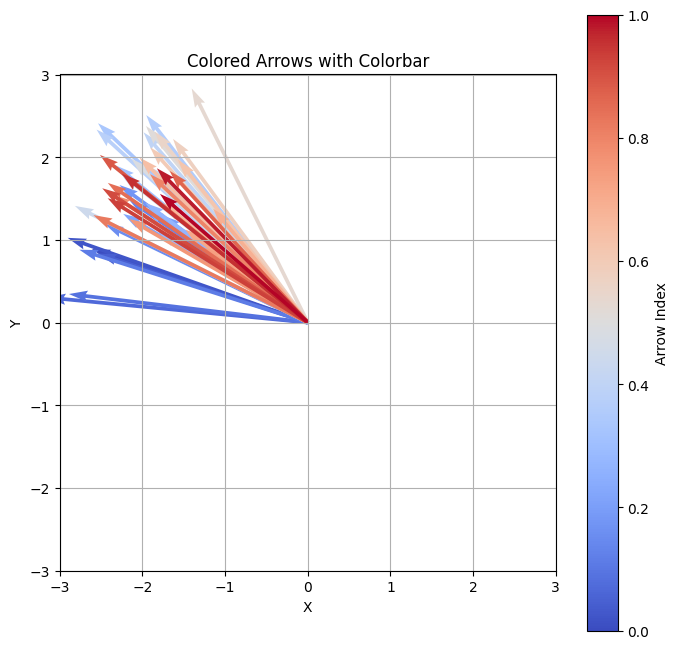

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize

def plot_colored_arrows(wd, ws, origin_x=0, origin_y=0, color_by='index'):
    wd = np.array(wd)
    ws = np.array(ws)
    n = len(wd)
    assert wd.shape == ws.shape, "Angle and magnitude arrays must match"

    # Compute vector components
    theta = np.deg2rad(wd)
    u = ws * np.cos(theta)
    v = ws * np.sin(theta)

    # Starting positions
    x0 = np.full_like(u, origin_x)
    y0 = np.full_like(v, origin_y)

    # Values to color by (either index or magnitude)
    if color_by == 'index':
        color_values = np.linspace(0, 1, n)
        label = "Arrow Index"
    elif color_by == 'magnitude':
        color_values = (ws - ws.min()) / (ws.max() - ws.min() + 1e-8)
        label = "Magnitude"
    else:
        raise ValueError("color_by must be 'index' or 'magnitude'")

    cmap = get_cmap('coolwarm')  # red to blue
    norm = Normalize(vmin=0, vmax=1)

    # Create quiver plot
    fig, ax = plt.subplots(figsize=(8, 8))
    q = ax.quiver(x0, y0, u, v, color_values, cmap=cmap, norm=norm, angles='xy', scale_units='xy', scale=1)

    # Add colorbar
    cbar = fig.colorbar(q, ax=ax)
    cbar.set_label(label)

    ax.set_aspect('equal')
    ax.set_title("Colored Arrows with Colorbar")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.grid(True)

plot_colored_arrows(wd, ws)
plt.xlim(-3,3)
plt.ylim(-3,3)

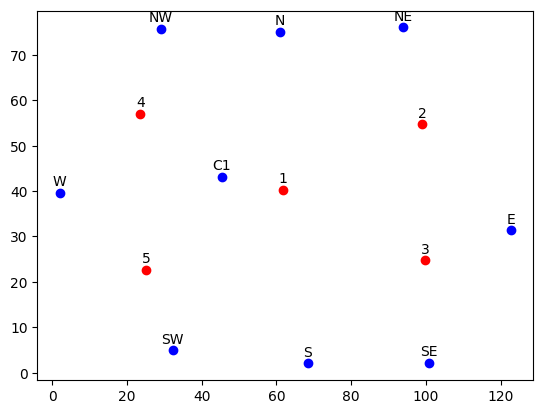

In [34]:
fig,ax = plt.subplots()
ax.scatter(source_location[:,0],source_location[:,1],color='red')
ax.scatter(sensor_points[:,0],sensor_points[:,1],color='blue')

labels = df_sensor['name']
for i, label in enumerate(labels):
    plt.annotate(label, (df_sensor.x[i], df_sensor.y[i]), textcoords="offset points", xytext=(0,5), ha='center')
for i in range(len(source_location)):
    plt.annotate(str(i+1), (source_location[i,0],source_location[i,1]), textcoords="offset points", xytext=(0,5), ha='center')

In [35]:
print(sensor_values_fn['NW'](16))

tensor(0.8561, dtype=torch.float64)


In [36]:
sensor_values_fn = dict()
for name in sensor_names:
    sensor_values_fn[name] = interp1d(df_puff_simulation.index*60,df_puff_simulation[name])

sensor_values_fn_1 = dict()
for name in sensor_names:
    sensor_values_fn_1[name] = lambda t,x=sensor_values_fn[name] : torch.tensor(x(t))



print(sensor_values_fn['C1'](24*60))
print(sensor_values_fn_1['C1'](24*60))

11.9444936
tensor(11.9445, dtype=torch.float64)
